In [64]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import scipy.constants as sc
from pathlib import Path
from numpy.linalg import eigvals

#TODO: need test, probably have bugs

temperature = 700  # K
l = [2.527, 1.438]
# change the logic of bond order and angle order，l_array[1] rotated by angle[1]
Angle = np.deg2rad(np.array([-15, -15]))
rotation = np.array([0, 1])
labels = {
    1: {'label': 'thiophene-thiophene', 'color': 'b'},
    # 2: {'label': 'dihedralB', 'color': 'm'},
    # 3: {'label': 'T-E', 'color': 'c'},
    # 4: {"label": "FT-FT", "color": 'g'}, 
    # 5: {"label": "ADTDI-FT", "color": 'r'},
}

In [65]:
def read_data(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    if data[:, 0].max() - data[:, 0].min() != 360:
        mirrored = np.column_stack((-data[:, 0] + 360, data[:, 1]))
        combined = np.vstack((data, mirrored))
        combined = np.unique(combined, axis=0)
        return combined[np.argsort(combined[:, 0])]
    else:
        return data[np.argsort(data[:, 0])]


def fit_function(data_label):
    data = read_data(Path(f"{data_label['label']}.txt"))
    fitf = interp1d(data[:, 0],
                    data[:, 1],
                    kind='cubic',
                    fill_value="extrapolate")
    return fitf


def make_Mmat(all_data, Angle_rad, rotation_types, temperature):
    kTval = sc.R * temperature / 1000  # in kJ/mol
    M = len(rotation_types)
    A_list = []
    for i in range(M):
        rot_id = int(rotation_types[i])
        theta = float(Angle_rad[i])
        if rot_id == 0:
            m_i, s_i = 1.0, 0.0
        elif rot_id == -1:
            m_i, s_i = -1.0, 0.0
        else:
            fitf = all_data[rot_id]
            Z, _ = quad(lambda phi_deg: np.exp(-fitf(phi_deg) / kTval),
                        0,
                        360,
                        limit=1000)
            m_i, _ = quad(lambda phi_deg: np.cos(np.deg2rad(phi_deg)) * np.exp(
                -fitf(phi_deg) / kTval),
                          0,
                          360,
                          limit=1000)
            m_i /= Z
            s_i, _ = quad(lambda phi_deg: np.sin(np.deg2rad(phi_deg)) * np.exp(
                -fitf(phi_deg) / kTval),
                          0,
                          360,
                          limit=1000)
            s_i /= Z

        S = np.array([[m_i, -s_i, 0.0], [s_i, m_i, 0.0], [0.0, 0.0, 1.0]])
        c = np.cos(theta)
        s = np.sin(theta)
        R_y = np.array([[c, 0.0, s], [0.0, 1.0, 0.0], [-s, 0.0, c]])
        A_list.append(S @ R_y)

    # Multiply all A_i for the repeat unit
    Mmat = np.eye(3)
    for A in A_list:
        Mmat = A @ Mmat
    return Mmat
def compute_persistence_in_repeats(Mmat):
    """
    Calculates the persistence length in repeat units
    """
        # eigen values
    eigs = eigvals(Mmat)
    lambda_max = float(np.max(np.abs(eigs)))

    # if lambda_max is close to 1, numerical stability may be an issue; if >=1 (numerical error), clip to 1 - eps
    if lambda_max >= 1.0:
        eps = 1e-12
        if lambda_max > 1.0 + 1e-8:
            print("Warning: lambda_max > 1 (numerical error)")
        lambda_max = min(lambda_max, 1.0 - eps)

    # persistence length measured in number of repeat units:
    lp_in_repeats = -1.0 / np.log(lambda_max)
    return lp_in_repeats, lambda_max

In [ ]:
def compute_mean_square_end_to_end(N_p, l, N):
    L_repeat = np.sum(l)
    if N_p == np.inf:
        L = N * L_repeat
        return L**2
    else:
        return 2 * N_p * N * L_repeat**2 * (
            1 - N_p / N * (1 - np.exp(-N / N_p)))

In [ ]:
all_data = {}
for key, label_info in labels.items():
    all_data[key] = fit_function(label_info)
matrix = make_Mmat(all_data, Angle, rotation, temperature)
N_p, lambda_max = compute_persistence_in_repeats(matrix)
print(f"Persistence length in repeat units: {N_p}")

Persistence length in repeat units: 10.471736900837307


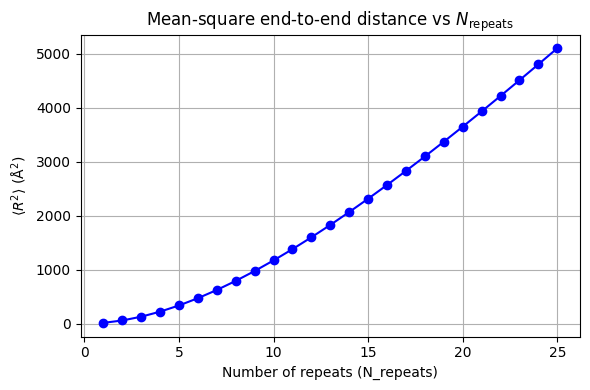

In [ ]:

N_vals = np.arange(1, 26)  # N_repeats = 1 到 25
R2_vals = compute_mean_square_end_to_end(N_p, l, N_vals)

plt.figure(figsize=(6,4))
plt.plot(N_vals, R2_vals, 'o-', color='b')
plt.xlabel("Number of repeats (N_repeats)")
plt.ylabel(r"$\langle R^2 \rangle$ (Å$^2$)")
plt.title(r"Mean-square end-to-end distance vs $N_{\mathrm{repeats}}$")
plt.grid(True)
plt.tight_layout()
plt.show()